<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#UK-Data" data-toc-modified-id="UK-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>UK Data</a></span></li><li><span><a href="#Load-data,-Fit-Model" data-toc-modified-id="Load-data,-Fit-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data, Fit Model</a></span></li><li><span><a href="#Display-Actual-vs-Prediction" data-toc-modified-id="Display-Actual-vs-Prediction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Display Actual vs Prediction</a></span></li><li><span><a href="#Commentary" data-toc-modified-id="Commentary-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Commentary</a></span><ul class="toc-item"><li><span><a href="#10th-April" data-toc-modified-id="10th-April-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>10th April</a></span></li><li><span><a href="#8th-April" data-toc-modified-id="8th-April-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>8th April</a></span></li><li><span><a href="#7th-April" data-toc-modified-id="7th-April-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>7th April</a></span></li><li><span><a href="#3rd-April" data-toc-modified-id="3rd-April-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>3rd April</a></span></li><li><span><a href="#31st-March" data-toc-modified-id="31st-March-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>31st March</a></span></li></ul></li><li><span><a href="#Previous-Model-Values" data-toc-modified-id="Previous-Model-Values-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Previous Model Values</a></span></li></ul></div>

## UK Data
Official figures are here:
* https://www.gov.uk/guidance/coronavirus-covid-19-information-for-the-public#number-of-cases-and-deaths

## Load data, Fit Model

In [6]:
import pandas as pd

# TODO: move this logic to the class. It can just as easily
# read the values

# Get our Country model data
country = 'United Kingdom'
meta_df = pd.read_csv('../data/raw/country_meta.csv', index_col='country')
start_str = meta_df.loc[country, 'start_str']
province = meta_df.loc[country, 'province']
duration_guess = meta_df.loc[country, 'duration_guess']
peak_guess = meta_df.loc[country, 'peak_guess']
population = meta_df.loc[country, 'start_str']
filepath = '../data/raw/'

In [7]:
import sys
from os import path
sys.path.append(path.pardir)
from src.covid import CovidCountry

# Load and fix UK data
fix_data = {'2020-03-12': 590,
            '2020-03-15': 1391,
            '2020-03-19': 3269,}

uk = CovidCountry(country=country,
                  province=province,
                  filepath=filepath,
                  fixes=fix_data)

uk.load(today=73758)

In [9]:
uk.fit(start_str=start_str,
       duration_guess=duration_guess,
       peak_guess=peak_guess)

gb_df = uk.predict()

## Display Actual vs Prediction

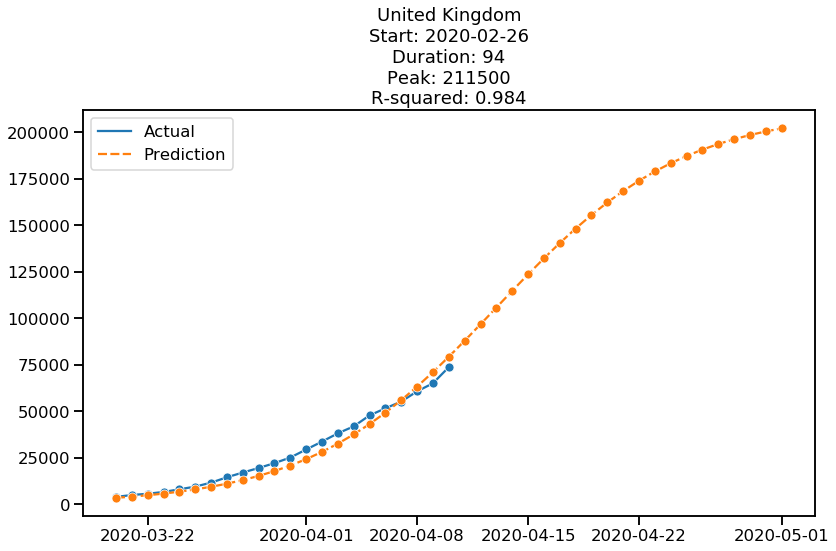

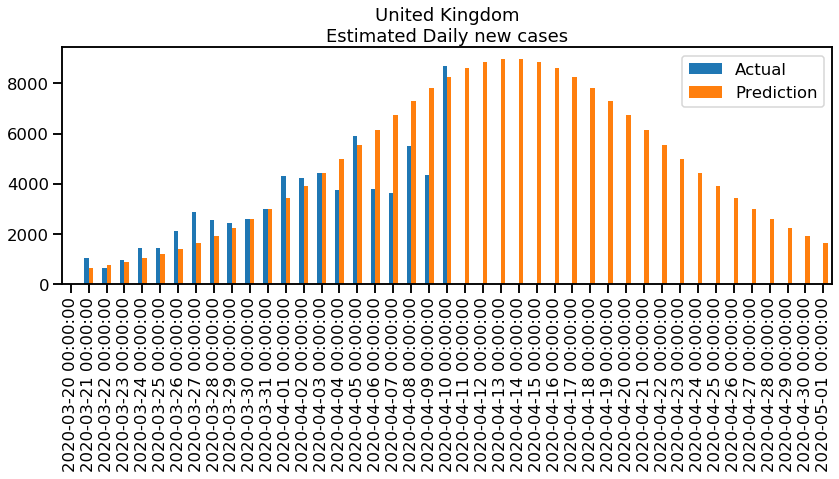

In [10]:
uk.display(offset=21)

## Commentary
### 10th April
UK was not including key worker tests - these were all added today to catch up. That adds about 300-500 a day going forward. That curve appears to lag the population - which makes sense. They catch it in hospital, and there is a lag in testing for those people - perhaps up to 2 weeks until testing catches up and becomes pro-active. i.e. the test capacity will exceed the requirement to measure people with symptoms, and can start testing people with no symptoms in order of risk such as ICU, transport teams etc.

### 8th April
I'm erring more towards longer duration. I've updated accordingly.

### 7th April
I'm pretty sure the peak will be before this Sunday - but its hard to know if our duration is longer like Italy, or shorter like Germany.

### 3rd April
I suspect the testing is now catching up. I've returned the duration guess to 7*12 days, my initial duration for Italy. I know this is the most optimistic case, but I've seen other countries in Europe; Spain, France and possibly Germany, all show durations less than the current Italian spread. As always this only remains true if people behave in a way the suppresses the spread. It should be clear by the end of next week if we've passed peak new daily cases.

### 31st March
The total tests could be close to, or exceeding the current capacity to propose each day. We had 7k total tests performed today, with 33% shown as positive. A week ago we performed 3k tests (well under the initially capacity) and this showed 12% positive test rate. I would expect that ratio to stay fairly constant unless:
- Hospitals are being more specific with symptoms and testing a smaller set, and this is the real case.
- Hospitals are still testing everybody, but the processing can't keep up at the moment, and the real cases are higher, and will show as bigger peaks in later days.

I tend towards the later explanation, so I'm going to keep the model stats close to Italy for now.


## Previous Model Values
This tracks the best model parameters as the virus spread.

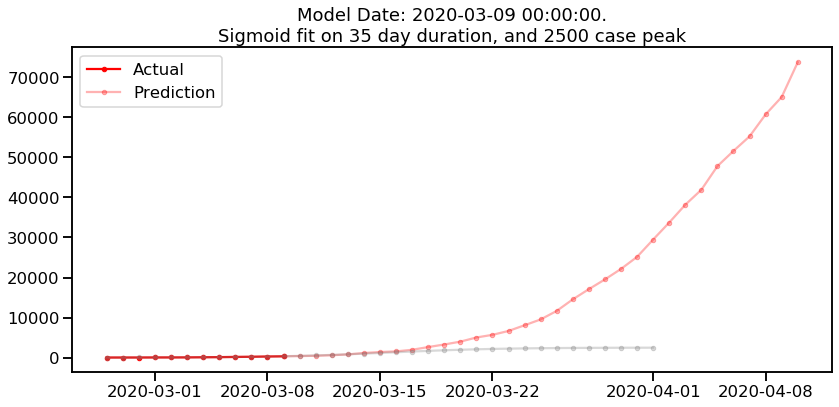

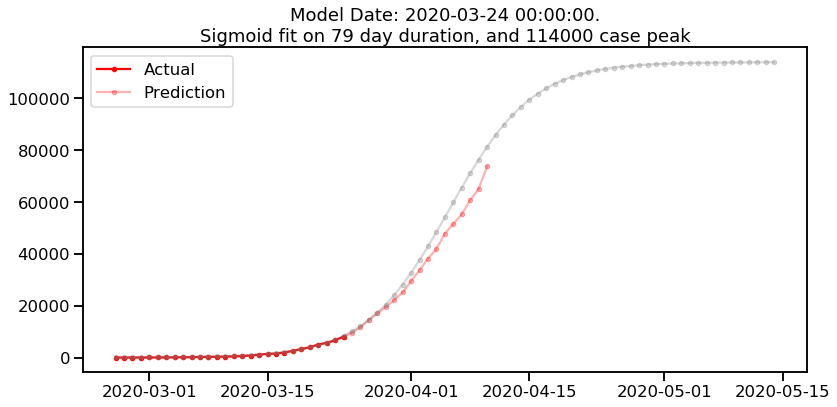

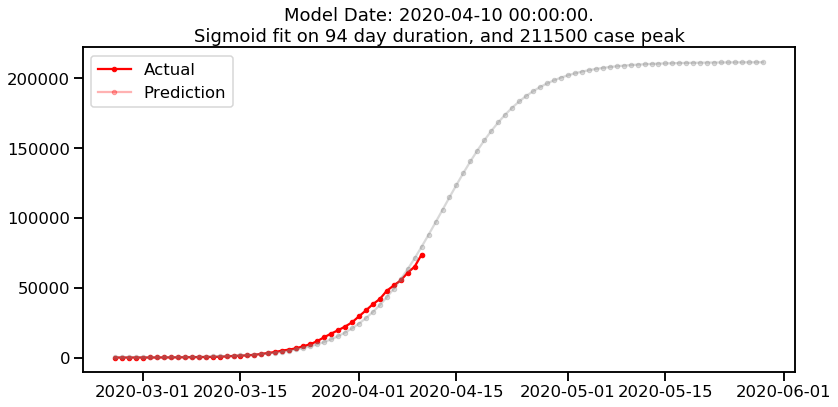

In [11]:
import src.covid as covid
import matplotlib.pyplot as plt

# Track best model parameter values over time
best_fit_df = pd.read_csv('../data/raw/gb_best_fit_params.csv', parse_dates=['date'], index_col='date')

# Plot fit for the first, middle and latest paramters
for date in best_fit_df.iloc[[0,int(len(best_fit_df)/2),-1]].index:
    sig_case_lst = []
    duration = best_fit_df.loc[date, 'duration']
    peak = best_fit_df.loc[date, 'peak']
    spread = best_fit_df.loc[date, 'spread']
    start = best_fit_df.loc[date, 'start']
    for i in range(0, duration):
        sig_case_lst.append(covid.sig_pred_case(i, duration=duration, peak=peak, spread=spread))
    pred_df = pd.DataFrame({'Prediction': sig_case_lst}, index=pd.date_range(start, periods=duration))

    fig, ax = plt.subplots(1,1,figsize=(12,6))
    plt.plot(gb_df.loc[start:date, 'Actual'], marker='.', color='red')
    plt.plot(gb_df.loc[date:, 'Actual'], marker='.', color='red', alpha=0.3)
    plt.plot(pred_df['Prediction'], marker='.', color='grey', alpha=0.3)
    plt.legend(['Actual', 'Prediction'])
    plt.title(f'Model Date: {date}.\nSigmoid fit on {duration} day duration, and {peak} case peak')
    plt.tight_layout()
    plt.show()

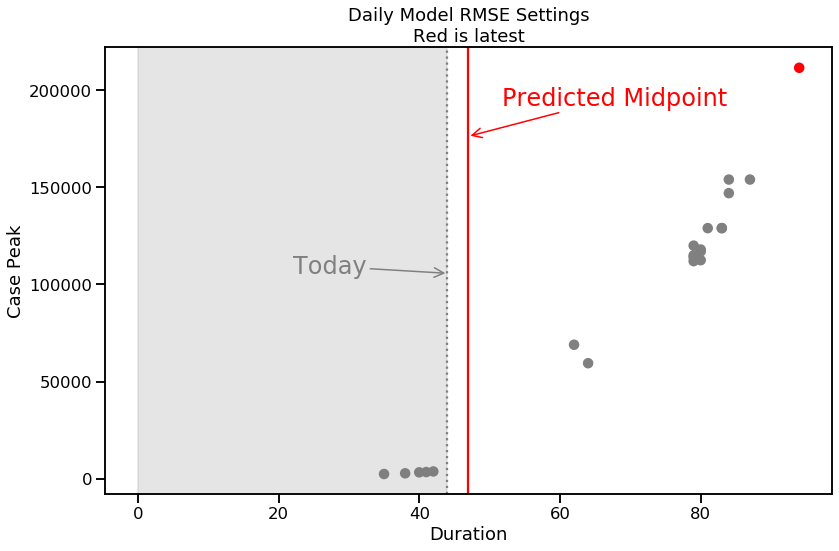

In [12]:
# Scatter plot the parameters
dur_so_far = pd.Timestamp.now() - gb_df.index.min()
dur_so_far /= pd.Timedelta('1D')
dur_so_far = np.floor(dur_so_far)

color_lst = ['gray'] * int(len(best_fit_df) - 1)
color_lst.append('red')

fig, ax = plt.subplots(1,1,figsize=(12, 8))
ax.scatter(y=best_fit_df['peak'],
           x=best_fit_df['duration'],
           c=color_lst)
text_color = 'grey'
plt.axvspan(xmin=0, xmax=dur_so_far, color='tab:grey', alpha=0.2)
plt.axvline(dur_so_far, color=text_color, linestyle=':')
plt.annotate(s='Today',
             xy=(dur_so_far, best_fit_df['peak'].max()/2),
             arrowprops={'arrowstyle': '->',
                         'color': text_color},
             xytext=(dur_so_far/2, best_fit_df['peak'].max()/2),
             color=text_color,
             fontsize=24)
pred_mid_point = best_fit_df['duration'][-1]/2
plt.axvline(pred_mid_point, color='red')
plt.annotate(s='Predicted Midpoint',
             xy=(pred_mid_point, best_fit_df['peak'].max()/1.2),
             arrowprops={'arrowstyle': '->',
                         'color': 'red'},
             xytext=(pred_mid_point*1.1, best_fit_df['peak'].max()/1.1),
             color='red',
             fontsize=24)
plt.title('Daily Model RMSE Settings\nRed is latest')
plt.ylabel('Case Peak')
plt.xlabel('Duration')
plt.tight_layout()
plt.show()